# Comparing IPO with equity market

- 1) Organize IPO and equity date
- 2) Import IPO and equity date
- 3) Define functions for matching firms and calculating return
- 4) Compare returns between IPO with MatchFirm
- 5) Discussion

### Result: There is almost no bias with $\pm 0.01\sigma$ towards IPO return ($\sim 250$ samples) after holding for just one year. This bias seems to increase over time, resulting in $\sim 0.3\sigma$ towards IPO return ($\sim 100$ samples) after holding for three years. There is a large increase in (mean) return between holding for 1-year and 2-year, then a moderate increase between 2-year and 3-year. The increase is not simply due to compounding; thus, there exists some form of acceleration.

In [1]:
import pandas as pd
import numpy as np

## 1) Organize IPO and equity data 

In [2]:
# Organize data for IPO price
bb_data = pd.read_csv('data/bloomberg_full_data copy.csv')

# Get IPO date, price and market capitalization
bb_data = bb_data[['STOCK_CODE', 'DATE', 'BLOOMBERG_CLOSE_PRICE','CUR_MKT_CAP']]
bb_data = bb_data.drop_duplicates()

# Arrange by date
ipo_price = pd.DataFrame(columns=bb_data['DATE'].unique())
for stock in bb_data['STOCK_CODE'].unique():
    data = bb_data[bb_data["STOCK_CODE"] == stock]
    timeSeries = pd.DataFrame([data['BLOOMBERG_CLOSE_PRICE'].to_list() + [str(stock)]], columns=(data['DATE'].to_list() + ['Stock']))
    ipo_price = pd.concat([ipo_price, timeSeries], ignore_index=True)

ipo_price = ipo_price.iloc[:, ::-1]

ipo_price.to_csv('resources/ipo_price_all.csv', index=False)

# Limit sample to 2020-01-01
end = ipo_price.columns.get_loc('2020-01-01')
ipo_price = ipo_price.iloc[:, :end+1]

ipo_price.to_csv('resources/ipo_price.csv', index=False)

In [3]:
# Organize data for equity market capitalization
eqt_mktcap = pd.read_csv('data/eqt_mktcap.csv', index_col=0)

# Get equity RIC and sector
sector = pd.read_excel('data/hkmkt_equity_industry_name (1).xlsm','Sheet1', usecols=['Type','TR1N'])
eqt_RIC = pd.read_csv('data/eqt_RIC.csv', usecols=['Type','RIC'])

eqt_mktcap['Name'] = eqt_RIC['RIC']
eqt_mktcap['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_mktcap.insert(1, 'Economic Sector', sector['TR1N'])

eqt_mktcap.to_csv('resources/eqt_mktcap_all.csv', index=False)

# Reduce sample to 2013-12-31
start = eqt_mktcap.columns.get_loc('2013-12-31')
eqt_mktcap = pd.concat([eqt_mktcap['Name'], eqt_mktcap['Economic Sector'], eqt_mktcap.iloc[:, start:]], axis=1)

eqt_mktcap.to_csv('resources/eqt_mktcap.csv', index=False)

In [4]:
# Select year-end market capitalization
select = ['Name','Economic Sector','2013-12-31','2014-12-31','2015-12-31','2016-12-30','2017-12-29','2018-12-31']
eqt_mktcap = eqt_mktcap.reindex(columns=select)
eqt_mktcap.columns=['Name','Economic Sector','2013','2014','2015','2016','2017','2018']

eqt_mktcap.to_csv('resources/eqt_mktcap_year.csv', index=False)

In [5]:
# Organize data for equity price
eqt_price = pd.read_csv('data/price.csv', index_col=0)

# Get equity RIC and sector
eqt_price['Name'] = eqt_RIC['RIC']
eqt_price['Name'] = eqt_price['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_price.insert(1, 'Economic Sector', sector['TR1N'])

eqt_price.to_csv('resources/eqt_price_all.csv', index=False)

# Reduce sample to 2013-12-31
start = eqt_price.columns.get_loc('2013-12-31')
eqt_price = pd.concat([eqt_price['Name'], eqt_price['Economic Sector'], eqt_price.iloc[:, start:]],axis=1)

eqt_price.to_csv('resources/eqt_price.csv', index=False)

## 2) Import IPO and equity data

In [6]:
# Import IPO general data
data_ipo = pd.read_csv('resources/data_ipo.csv')
data_ipo['Stock'] = data_ipo['Stock'].astype(str)
data_ipo['previous_year'] = data_ipo['previous_year'].astype(str)
data_ipo

,Stock,Industry,IPO,MktCap,IPO Year,previous_year
0,1353,Consumer Cyclicals,2014-09-01,160.79,2014,2013
1,1439,Basic Materials,2014-01-13,0.81,2014,2013
2,1247,Consumer Cyclicals,2014-01-15,2.81,2014,2013
3,3332,Consumer Cyclicals,2014-01-15,2.66,2014,2013
4,2080,Real Estate,2014-01-23,2.84,2014,2013
...,...,...,...,...,...,...
439,6049,Real Estate,2019-12-19,45.35,2019,2018
440,9928,Real Estate,2019-12-19,4.88,2019,2018
441,9909,Consumer Cyclicals,2019-12-30,10.06,2019,2018
442,9911,Consumer Cyclicals,2019-12-31,3.25,2019,2018


In [7]:
# Import equity market capitalization year data
eqt_mktcap = pd.read_csv('resources/eqt_mktcap_year.csv')
eqt_mktcap['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_mktcap

,Name,Economic Sector,2013,2014,2015,2016,2017,2018
0,700,Technology,920999.70,1054200.00,1434098.00,1797760.00,3856589.00,2989375.00
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,208838.60
2,939,Financials,1406440.00,1531457.00,1276615.00,1435290.00,1731004.00,1553095.00
3,941,Technology,1616244.00,1849676.00,1791603.00,1683083.00,1622680.00,1542826.00
4,1299,Financials,468511.40,519746.60,561453.10,527469.70,804767.60,785008.50
...,...,...,...,...,...,...,...,...
3439,nan,NaN,39318.50,39318.50,39318.50,39318.50,39318.50,39318.50
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,6389.48,6389.48,6389.48,6389.48,6389.48,6389.48


In [8]:
# Import equity price data
eqt_price = pd.read_csv('resources/eqt_price.csv')
eqt_price['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_price

,Name,Economic Sector,2013-12-31,2014-01-01,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,700,Technology,98.903,98.903,100.883,98.783,99.103,98.783,100.283,98.583,...,375.60,375.20,377.80,376.80,376.80,376.80,384.00,383.20,375.60,375.60
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.50,102.00,101.00,102.30,102.30,102.30,102.70,102.50,101.90,101.90
2,939,Financials,5.850,5.850,5.820,5.680,5.590,5.560,5.640,5.540,...,6.64,6.62,6.68,6.63,6.63,6.63,6.76,6.75,6.73,6.73
3,941,Technology,80.400,80.400,80.200,78.600,78.150,78.050,78.450,77.350,...,62.45,63.95,63.70,64.25,64.25,64.25,65.40,65.80,65.50,65.50
4,1299,Financials,38.900,38.900,39.350,38.450,38.100,37.750,37.700,37.700,...,80.15,79.90,79.20,79.40,79.40,79.40,80.95,82.15,81.80,81.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3) Define functions for matching firms and calculating return

In [9]:
from datetime import datetime, timedelta

In [10]:
def find_matching_firm(mktdf, industry, mktcap, year):
    
    sameIndustry = mktdf[mktdf['Economic Sector'] == industry]
    minDiff = float('inf')
    match = 'Name'
    
    for index, row in sameIndustry.iterrows():
        diff = abs(row[year] - mktcap)
        if diff < minDiff:
            minDiff = diff
            match = row['Name']
    
    return match

In [11]:
def calculate_return_hold(dailydf, stock, start, weeks):
    
    end = datetime.strptime(start,"%Y-%m-%d") + timedelta(weeks=weeks)
    end = end.strftime("%Y-%m-%d")
    
    i = dailydf.columns.get_loc(start)
    j = dailydf.columns.get_loc(end)
    
    hold = dailydf.loc[dailydf.iloc[:,0] == stock].iloc[:,i+1:j+1].values
    return np.prod(hold + 1) - 1

In [12]:
def calculate_return_regular(pricedf, stock, start, weeks):
    
    end = datetime.strptime(start,"%Y-%m-%d") + timedelta(weeks=weeks)
    end = end.strftime("%Y-%m-%d")
    
    i = pricedf.columns.get_loc(start)
    j = pricedf.columns.get_loc(end)
    
    start_price = pricedf.loc[pricedf.iloc[:,0] == stock].iloc[:, i].values[0]
    end_price = pricedf.loc[pricedf.iloc[:,0] == stock].iloc[:, j].values[0]
    return end_price/start_price - 1

## 4) Compare returns between IPO with MatchFirm

In [13]:
# Calculate daily return for equity
eqt_daily_return = eqt_price[['Name', 'Economic Sector']].copy()
for i in range(len(eqt_price.columns)):
    if i < 3: continue
    eqt_daily_return[eqt_price.columns[i]] = (eqt_price.iloc[:, i] - eqt_price.iloc[:, i-1]) / eqt_price.iloc[:, i-1]

eqt_daily_return

,Name,Economic Sector,2014-01-01,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,700,Technology,0.0,0.020020,-0.020816,0.003239,-0.003229,0.015185,-0.016952,0.008926,...,-0.005297,-0.001065,0.006930,-0.002647,0.0,0.0,0.019108,-0.002083,-0.019833,0.0
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003880,-0.014493,-0.009804,0.012871,0.0,0.0,0.003910,-0.001947,-0.005854,0.0
2,939,Financials,0.0,-0.005128,-0.024055,-0.015845,-0.005367,0.014388,-0.017730,0.001805,...,0.001508,-0.003012,0.009063,-0.007485,0.0,0.0,0.019608,-0.001479,-0.002963,0.0
3,941,Technology,0.0,-0.002488,-0.019950,-0.005725,-0.001280,0.005125,-0.014022,0.005818,...,0.005636,0.024019,-0.003909,0.008634,0.0,0.0,0.017899,0.006116,-0.004559,0.0
4,1299,Financials,0.0,0.011568,-0.022872,-0.009103,-0.009186,-0.001325,0.000000,-0.002653,...,-0.014145,-0.003119,-0.008761,0.002525,0.0,0.0,0.019521,0.014824,-0.004260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Helper function to create peers dataframe
def calculate_peers(data, peers, holdWeeks):
    
    for index, ipo in data[0].iterrows():
    
        name = ipo['Stock']
        industry = ipo['Industry']
        mktcap = ipo['MktCap']
        prevYear = ipo['previous_year']

        date = ipo['IPO']
        if datetime.strptime(date, "%Y-%m-%d") + timedelta(weeks=holdWeeks) > datetime.strptime("2020-01-01", "%Y-%m-%d"):
            continue

        match = find_matching_firm(data[1], industry, mktcap, prevYear)
        #matchReturn = calculate_return_regular(data[2], match, date, holdWeeks)
        matchReturn = calculate_return_hold(data[3], match, date, holdWeeks)
        #ipoReturn = calculate_return_regular(data[2], name, date, holdWeeks)
        ipoReturn = calculate_return_hold(data[3], name, date, holdWeeks)

        group = {'IPO': name,
                 'IPO return': ipoReturn,
                 'MatchFirm': match,
                 'MatchFirm return': matchReturn,
                 'Industry': industry,
                 'IPO Date': date}
        peers = peers.append(group, ignore_index=True)
    
    return peers

In [28]:
# Create DataFrame to compare peers
peersdf = pd.DataFrame(columns=['IPO','IPO return','MatchFirm','MatchFirm return', 'Industry', 'IPO Date'])

# Calculate return after some weeks of holding
data = [data_ipo, eqt_mktcap, eqt_price, eqt_daily_return]
years = 3
holdWeeks = [52, 104, 156]

peers = []
for i in range(years):
    peers.append(calculate_peers(data, peersdf, holdWeeks[i]))

peers[0]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
0,1353,0.000000,8172,2.797101,Consumer Cyclicals,2014-09-01
1,1439,-0.061728,8227,0.200000,Basic Materials,2014-01-13
2,1247,-0.669039,8273,NaN,Consumer Cyclicals,2014-01-15
3,3332,-0.443609,8273,NaN,Consumer Cyclicals,2014-01-15
4,2080,-0.665493,736,-0.033189,Real Estate,2014-01-23
...,...,...,...,...,...,...
321,1762,-0.366667,8010,0.000000,Consumer Cyclicals,2018-12-21
322,3978,0.495833,8363,0.718750,Academic & Educational Services,2018-12-27
323,1713,0.067797,1265,-0.166667,Utilities,2018-12-28
324,1759,0.091549,1265,-0.166667,Utilities,2018-12-28


In [31]:
peers[0].to_csv('ipo_matchingfirm_return.csv')

## 5) Discussion

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

### There are also some straggling NaN values in the data.

In [18]:
# Remove NaN values
filtered = []
for i in range(years):
    filtered.append(peers[i].dropna())

filtered[0]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
0,1353,0.000000,8172,2.797101,Consumer Cyclicals,2014-09-01
1,1439,-0.061728,8227,0.200000,Basic Materials,2014-01-13
4,2080,-0.665493,736,-0.033189,Real Estate,2014-01-23
5,2226,-0.513906,3997,-0.031250,Consumer Non-Cyclicals,2014-01-28
6,2638,-0.018727,1250,1.156250,Utilities,2014-01-29
...,...,...,...,...,...,...
321,1762,-0.366667,8010,0.000000,Consumer Cyclicals,2018-12-21
322,3978,0.495833,8363,0.718750,Academic & Educational Services,2018-12-27
323,1713,0.067797,1265,-0.166667,Utilities,2018-12-28
324,1759,0.091549,1265,-0.166667,Utilities,2018-12-28


### Comparing the difference and ratio between IPO return and MatchFirm return.

### There is almost no bias with $\pm 0.01\sigma$ towards IPO return ($\sim 250$ samples) after holding for just one year. This bias seems to increase over time, resulting in $\sim 0.3\sigma$ towards IPO return ($\sim 100$ samples) after holding for three years. There is a large increase in (mean) return between holding for 1-year and 2-year, then a moderate increase between 2-year and 3-year. The increase is not simply due to compounding; thus, there exists some form of acceleration. This change is more obvious for the ratio comparison.

In [19]:
# Remove outliers from difference comparison
compare_diff = []
dist_diff = []
outliers_diff = []

for i in range(years):
    compare_diff.append(pd.DataFrame())
    compare_diff[i][['IPO','MatchFirm','Industry']] = filtered[i][['IPO','MatchFirm','Industry']]
    compare_diff[i]['difference'] = filtered[i]['IPO return'] - filtered[i]['MatchFirm return']
    outliers_diff.append(pd.DataFrame(columns=['IPO','MatchFirm','Industry','difference']))
    
    while True:
        mu, sigma = norm.fit(compare_diff[i]['difference'].to_list())
        if compare_diff[i].loc[(compare_diff[i]['difference'] - mu).apply(abs) > 3*sigma, 'difference'].empty:
            dist_diff.append((mu, sigma))
            break
        outlier = (compare_diff[i][['difference']] - mu).apply(abs).idxmax().values[0]
        outliers_diff[i] = outliers_diff[i].append(compare_diff[i].loc[[outlier]])
        compare_diff[i] = compare_diff[i].drop([outlier])

outliers_diff[0]

,IPO,MatchFirm,Industry,difference
179,1660,8188,Industrials,37.335385
72,1027,8010,Consumer Cyclicals,19.203488
197,1630,442,Consumer Cyclicals,11.662823
257,1671,1265,Utilities,7.834694
48,1395,1250,Utilities,-6.880319
74,1430,3966,Utilities,-6.055723
35,1321,736,Real Estate,5.303869
253,2116,8139,Basic Materials,-4.485193
23,6128,736,Real Estate,-4.417535
28,3639,736,Real Estate,-4.338547


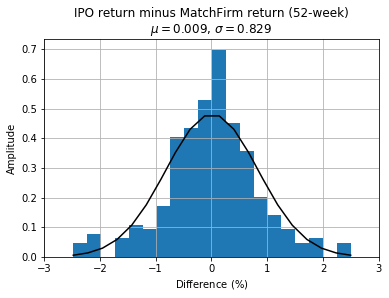

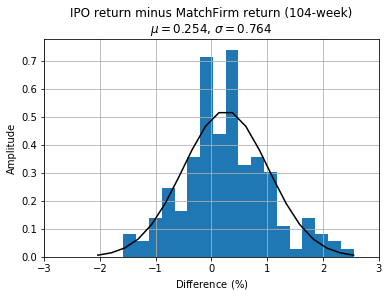

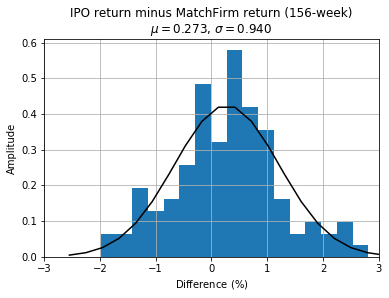

In [20]:
# Generate graphs for difference comparison
for i in range(years):
    plt.figure()
    
    graph = compare_diff[i]['difference'].to_list()
    bins = 20
    xmin, xmax = dist_diff[i][0]-3*dist_diff[i][1], dist_diff[i][0]+3*dist_diff[i][1]
    plt.hist(graph, bins=bins, range=(xmin, xmax), density=True)
    
    x = np.linspace(xmin, xmax, bins)
    fit = norm.pdf(x, dist_diff[i][0], dist_diff[i][1])
    plt.plot(x, fit, 'k')

    plt.title('IPO return minus MatchFirm return ({}-week)\n$\mu={:.3f}$, $\sigma={:.3f}$'.format(holdWeeks[i], dist_diff[i][0], dist_diff[i][1]))
    plt.xlabel('Difference ($\%$)')
    plt.ylabel('Amplitude')
    plt.xlim(-3,3)
    plt.grid(True)
    
    plt.savefig('resources/graph_difference_{}week.png'.format(holdWeeks[i]))

In [21]:
# Remove outliers from ratio comparison
compare_ratio = []
dist_ratio = []
outliers_ratio = []

for i in range(years):
    compare_ratio.append(pd.DataFrame())
    compare_ratio[i][['IPO','MatchFirm','Industry']] = filtered[i][['IPO','MatchFirm','Industry']]
    compare_ratio[i]['ratio'] = (filtered[i]['IPO return']+1) / (filtered[i]['MatchFirm return']+1)
    outliers_ratio.append(pd.DataFrame(columns=['IPO','MatchFirm','Industry','ratio']))
    
    while True:
        mu, sigma = norm.fit(np.log10(compare_ratio[i]['ratio'].to_list()))
        if compare_ratio[i].loc[(compare_ratio[i]['ratio'] - mu).apply(np.log10) > 3*sigma, 'ratio'].empty:
            dist_ratio.append((mu, sigma))
            break
        outlier = (compare_ratio[i][['ratio']].apply(np.log10) - mu).apply(abs).idxmax().values[0]
        outliers_ratio[i] = outliers_ratio[i].append(compare_ratio[i].loc[[outlier]])
        compare_ratio[i] = compare_ratio[i].drop([outlier])

outliers_ratio[0]

,IPO,MatchFirm,Industry,ratio
179,1660,8188,Industrials,97.301587
197,1630,442,Consumer Cyclicals,32.166200
72,1027,8010,Consumer Cyclicals,20.203488


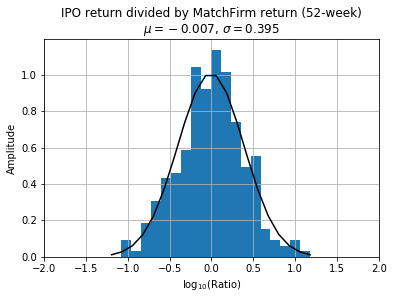

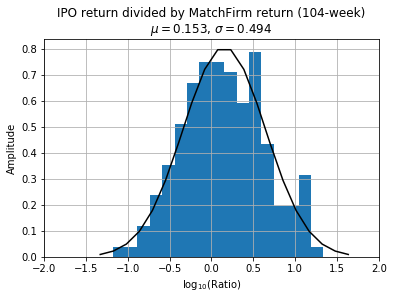

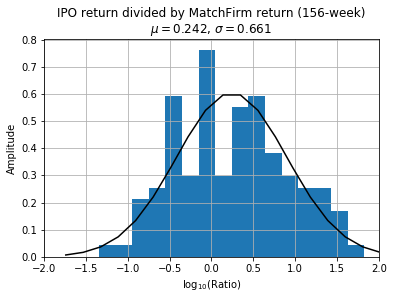

In [22]:
# Generate graphs for difference comparison
for i in range(years):
    plt.figure()
    
    graph = np.log10(compare_ratio[i]['ratio'].to_list())
    bins = 20
    xmin, xmax = dist_ratio[i][0]-3*dist_ratio[i][1], dist_ratio[i][0]+3*dist_ratio[i][1]
    plt.hist(graph, bins=bins, range=(xmin, xmax), density=True)
    
    x = np.linspace(xmin, xmax, bins)
    fit = norm.pdf(x, dist_ratio[i][0], dist_ratio[i][1])
    plt.plot(x, fit, 'k')

    plt.title('IPO return divided by MatchFirm return ({}-week)\n$\mu={:.3f}$, $\sigma={:.3f}$'.format(holdWeeks[i], dist_ratio[i][0], dist_ratio[i][1]))
    plt.xlabel('$\log_{10}$(Ratio)')
    plt.ylabel('Amplitude')
    plt.xlim(-2,2)
    plt.grid(True)
    
    plt.savefig('resources/graph_ratio_{}week.png'.format(holdWeeks[i]))

### It is unclear to me why the "holding" calculation is prefered to find the return. Compounding daily changes should be mathematically the same as taking the average over time. The (lack of) difference between the "holding" calculation and "regular" (averaging) calculation is examined below.

In [23]:
# Create DataFrame to compare peers
diff = pd.DataFrame(columns=['IPO','IPO return diff','MatchFirm','MatchFirm return diff'])

# Calculate return after some weeks of holding
holdWeeks = 156
for index, ipo in data[0].iterrows():
    
    name = ipo['Stock']
    industry = ipo['Industry']
    mktcap = ipo['MktCap']
    prevYear = ipo['previous_year']
    
    date = ipo['IPO']
    if datetime.strptime(date, "%Y-%m-%d") + timedelta(weeks=holdWeeks) > datetime.strptime("2020-01-01", "%Y-%m-%d"):
        continue
    
    match = find_matching_firm(data[1], industry, mktcap, prevYear)
    matchReturn1 = calculate_return_regular(data[2], match, date, holdWeeks)
    matchReturn2 = calculate_return_hold(data[3], match, date, holdWeeks)
    ipoReturn1 = calculate_return_regular(data[2], name, date, holdWeeks)
    ipoReturn2 = calculate_return_hold(data[3], name, date, holdWeeks)
    
    group = {'IPO': name,
             'IPO return diff': abs(ipoReturn1 - ipoReturn2),
             'MatchFirm': match,
             'MatchFirm return diff': abs(matchReturn1 - matchReturn2),}
    diff = diff.append(group, ignore_index=True)

diff

,IPO,IPO return diff,MatchFirm,MatchFirm return diff
0,1353,0.000000e+00,8172,2.220446e-15
1,1439,3.552714e-15,8227,2.220446e-14
2,1247,2.220446e-16,8273,NaN
3,3332,4.440892e-16,8273,NaN
4,2080,9.992007e-16,736,0.000000e+00
...,...,...,...,...
164,1632,8.881784e-16,442,8.881784e-16
165,1617,1.776357e-15,8301,2.220446e-16
166,1357,6.661338e-16,8301,3.330669e-16
167,1580,6.661338e-16,8139,5.551115e-16


In [24]:
print("Difference in IPO return calculations")
print(sorted(diff['IPO return diff'].dropna().to_list(), reverse=True)[:5])
print("\nDifference in MatchFirm return calculations")
print(sorted(diff['MatchFirm return diff'].dropna().to_list(), reverse=True)[:5])

Difference in IPO return calculations
[4.085620730620576e-14, 2.4868995751603507e-14, 1.687538997430238e-14, 1.4654943925052066e-14, 1.3766765505351941e-14]

Difference in MatchFirm return calculations
[2.220446049250313e-14, 2.042810365310288e-14, 1.7763568394002505e-14, 1.4210854715202004e-14, 1.1102230246251565e-14]


In [37]:
# Create DataFrame to compare peers
peersdf = pd.DataFrame(columns=['IPO','IPO return','MatchFirm','MatchFirm return', 'Industry', 'IPO Date'])

# Calculate return after some weeks of holding
data = [data_ipo, eqt_mktcap, eqt_price, eqt_daily_return]
years = 3
holdWeeks = [52, 104, 156]

peers = []
for i in range(years):
    peers.append(calculate_peers(data, peersdf, holdWeeks[i]))

peers[1]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
0,1353,0.000000,8172,0.246377,Consumer Cyclicals,2014-09-01
1,1439,0.135802,8227,1.146341,Basic Materials,2014-01-13
2,1247,-0.782918,8273,NaN,Consumer Cyclicals,2014-01-15
3,3332,-0.003759,8273,NaN,Consumer Cyclicals,2014-01-15
4,2080,-0.468310,736,-0.767627,Real Estate,2014-01-23
...,...,...,...,...,...,...
223,1727,0.058296,8188,-0.355556,Industrials,2017-12-15
224,1722,-0.464198,8188,-0.355556,Industrials,2017-12-15
225,1789,2.337121,8247,-0.072115,Healthcare,2017-12-20
226,3878,1.492063,8188,-0.243636,Industrials,2017-12-22


In [42]:
peers[1].to_csv('2year_ipo_matching_return.csv')

In [40]:
# Create DataFrame to compare peers
peersdf = pd.DataFrame(columns=['IPO','IPO return','MatchFirm','MatchFirm return', 'Industry', 'IPO Date'])

# Calculate return after some weeks of holding
data = [data_ipo, eqt_mktcap, eqt_price, eqt_daily_return]
years = 3
holdWeeks = [52, 104, 156]

peers = []
for i in range(years):
    peers.append(calculate_peers(data, peersdf, holdWeeks[i]))

peers[2]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
0,1353,0.000000,8172,0.188406,Consumer Cyclicals,2014-09-01
1,1439,0.987654,8227,5.878049,Basic Materials,2014-01-13
2,1247,-0.887900,8273,NaN,Consumer Cyclicals,2014-01-15
3,3332,-0.379699,8273,NaN,Consumer Cyclicals,2014-01-15
4,2080,-0.457746,736,-0.876395,Real Estate,2014-01-23
...,...,...,...,...,...,...
164,1632,-0.429875,442,-0.695349,Consumer Cyclicals,2016-11-29
165,1617,1.540230,8301,-0.820833,Technology,2016-12-12
166,1357,-0.836471,8301,-0.823288,Technology,2016-12-15
167,1580,-0.404762,8139,-0.529508,Basic Materials,2016-12-19


In [41]:
peers[2].to_csv('3year_ipo_matching_return.csv')